<a href="https://colab.research.google.com/github/Tejaswini-AnalyticsExpert/Supply-Chain-Management/blob/main/Spplier_Wise_Risk_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ================================================================
# 📄 Supplier-wise Risk Report (Without 856)
# ================================================================
import pandas as pd
import os

# ---------- Load Data ----------
in_path = "/content/Data Received Details.xlsx"
df = pd.read_excel(in_path)
df.columns = df.columns.str.strip()

# ---------- Convert relevant columns to numeric 0-100 ----------
def to_numeric_percent(x):
    if pd.isna(x):
        return 0.0
    s = str(x).strip().replace('%','').lower()
    if s in ('yes','y','true','t'):
        return 100.0
    if s in ('no','n','false','f'):
        return 0.0
    try:
        v = float(s)
        if 0 <= v <= 1:
            return v * 100
        return max(0.0, min(100.0, v))
    except:
        pass
    try:
        pd.to_datetime(s)
        return 100.0
    except:
        return 0.0

df['846_num'] = df['Inventory Data Received (846)'].apply(to_numeric_percent)
df['852_avg'] = (df['Production Plan Data Received (852)'].apply(to_numeric_percent) +
                 df['Production Actual Data Received (852)'].apply(to_numeric_percent)) / 2

# ---------- Risk classification ----------
def risk_level(x):
    if x == 100:
        return "Good"
    elif x == 0:
        return "High Risk"
    elif 25 < x <= 50:
        return "Medium Risk"
    elif 50 < x < 100:
        return "Low Risk"
    else:
        return "Unknown"

df['846_Risk'] = df['846_num'].apply(risk_level)
df['852_Risk'] = df['852_avg'].apply(risk_level)

# ---------- Compute Overall Risk (based on 846 and 852) ----------
def overall_risk(row):
    risks = [row['846_Risk'], row['852_Risk']]
    if "High Risk" in risks:
        return "High Risk"
    elif "Medium Risk" in risks:
        return "Medium Risk"
    elif "Low Risk" in risks:
        return "Low Risk"
    else:
        return "Good"

df['Overall_Risk'] = df.apply(overall_risk, axis=1)

# ---------- Prepare folder ----------
folder_path = "/content/Supplier_Wise_Risk_Report_846_852"
os.makedirs(folder_path, exist_ok=True)

# ---------- Save all suppliers in one Excel ----------
output_file = os.path.join(folder_path, "All_Suppliers_Risk_Report_846_852.xlsx")
final_cols = ['Item Category','Supplier','Location','846_Risk','852_Risk','Overall_Risk']
df[final_cols].to_excel(output_file, index=False)

print(f"✅ Supplier-wise risk report (without 856) saved in: {output_file}")


✅ Supplier-wise risk report (without 856) saved in: /content/Supplier_Wise_Risk_Report_846_852/All_Suppliers_Risk_Report_846_852.xlsx


In [4]:
# ================================================================
# 📁 Category-wise Compliance Report (One Excel per Folder, Multi-Sheet)
# ================================================================
import pandas as pd
import os
import re

# ---------- Helper to sanitize sheet names ----------
def sanitize_sheet_name(name):
    """Excel sheet names cannot contain: : \ / ? * [ ] and max 31 chars"""
    name = re.sub(r'[:\\/*?\[\]]', '_', str(name))
    return name[:31]

# ---------- Load Data ----------
in_path = "/content/Data Received Details.xlsx"
df = pd.read_excel(in_path)
df.columns = df.columns.str.strip()

# ---------- Helper: convert to numeric 0-100 ----------
def to_numeric_percent(x):
    if pd.isna(x):
        return 0.0
    s = str(x).strip().replace('%','').lower()
    if s in ('yes','y','true','t'):
        return 100.0
    if s in ('no','n','false','f'):
        return 0.0
    try:
        v = float(s)
        if 0 <= v <= 1:
            return v * 100
        return max(0.0, min(100.0, v))
    except:
        pass
    try:
        pd.to_datetime(s)
        return 100.0
    except:
        return 0.0

# ---------- Convert relevant columns ----------
cols_numeric = [
    'Inventory Data Received (846)',
    'Ship Data Received (856)',
    'Production Plan Data Received (852)',
    'Production Actual Data Received (852)'
]

for col in cols_numeric:
    df[col + '_num'] = df[col].apply(to_numeric_percent)

# ---------- Risk classification ----------
def risk_level(x):
    if x == 100:
        return "Good"
    elif x == 0:
        return "High Risk"
    elif 25 < x <= 50:
        return "Medium Risk"
    elif 50 < x < 100:
        return "Low Risk"
    else:
        return "Unknown"

df['846_Risk'] = df['Inventory Data Received (846)_num'].apply(risk_level)
df['856_Risk'] = df['Ship Data Received (856)_num'].apply(risk_level)
df['_852_avg'] = (df['Production Plan Data Received (852)_num'] + df['Production Actual Data Received (852)_num'])/2
df['852_Risk'] = df['_852_avg'].apply(risk_level)

# ---------- Prepare folders ----------
base_path = "/content"
folders = {
    '846_Risk': os.path.join(base_path, 'Category_Wise_Compliance_846'),
    '852_Risk': os.path.join(base_path, 'Category_Wise_Compliance_852'),
    '856_Risk': os.path.join(base_path, 'Category_Wise_Compliance_856')
}

for path in folders.values():
    os.makedirs(path, exist_ok=True)

# ---------- Risk levels ----------
risk_levels = ['Good','Low Risk','Medium Risk','High Risk']
metrics = {'846_Risk': 'Inventory 846', '852_Risk': 'Production 852', '856_Risk': 'Ship 856'}

# ---------- Generate Excel per folder ----------
for metric, metric_name in metrics.items():
    folder_path = folders[metric]
    file_path = os.path.join(folder_path, f"{metric_name.replace(' ','_')}_Category_Report.xlsx")

    categories = df['Item Category'].unique()

    with pd.ExcelWriter(file_path) as writer:
        # ----- One sheet per category -----
        for category in categories:
            category_df = df[df['Item Category'] == category][['Supplier','Location', metric]].copy()
            category_df.rename(columns={metric:'Risk Level'}, inplace=True)
            sheet_name = sanitize_sheet_name(category)
            category_df.to_excel(writer, sheet_name=sheet_name, index=False)

        # ----- Summary sheet -----
        summary_list = []
        for category in categories:
            temp = df[df['Item Category'] == category]
            counts = temp[metric].value_counts()
            summary_list.append({
                'Item Category': category,
                **{level: counts.get(level,0) for level in risk_levels}
            })
        summary_df = pd.DataFrame(summary_list)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)

print("✅ Category-wise compliance Excel reports created in folders:")
for f, path in folders.items():
    print(f"{f}: {path}")


<>:10: SyntaxWarning: invalid escape sequence '\ '
<>:10: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-363013262.py:10: SyntaxWarning: invalid escape sequence '\ '
  """Excel sheet names cannot contain: : \ / ? * [ ] and max 31 chars"""


✅ Category-wise compliance Excel reports created in folders:
846_Risk: /content/Category_Wise_Compliance_846
852_Risk: /content/Category_Wise_Compliance_852
856_Risk: /content/Category_Wise_Compliance_856


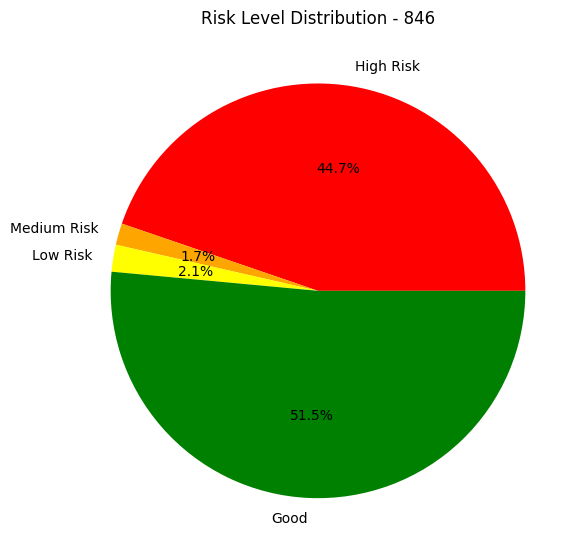

✅ Pie chart saved in: /content/Supplier_Wise_Risk_Report_846_852/Risk_846_Pie_Chart.png


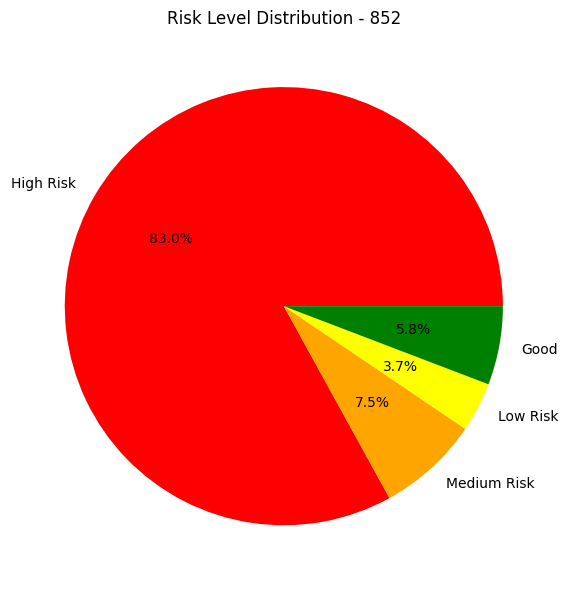

✅ Pie chart saved in: /content/Supplier_Wise_Risk_Report_846_852/Risk_852_Pie_Chart.png


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- Load the report ----------
folder_path = "/content/Supplier_Wise_Risk_Report_846_852"
file_path = os.path.join(folder_path, "All_Suppliers_Risk_Report_846_852.xlsx")
df = pd.read_excel(file_path)

# ---------- Define colors ----------
colors = {
    'High Risk': 'red',
    'Medium Risk': 'orange',
    'Low Risk': 'yellow',
    'Good': 'green'
}

# ---------- Function to plot pie chart ----------
def plot_risk_pie(series, title, save_path):
    risk_counts = series.value_counts()
    risk_percentages = (risk_counts / risk_counts.sum()) * 100

    plt.figure(figsize=(6,6))
    plt.pie(
        [risk_percentages.get(k, 0) for k in ['High Risk','Medium Risk','Low Risk','Good']],
        labels=['High Risk','Medium Risk','Low Risk','Good'],
        autopct='%1.1f%%',
        colors=[colors[k] for k in ['High Risk','Medium Risk','Low Risk','Good']]
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"✅ Pie chart saved in: {save_path}")

# ---------- Plot pie chart for 846 ----------
plot_risk_pie(
    df['846_Risk'],
    "Risk Level Distribution - 846",
    os.path.join(folder_path, "Risk_846_Pie_Chart.png")
)

# ---------- Plot pie chart for 852 ----------
plot_risk_pie(
    df['852_Risk'],
    "Risk Level Distribution - 852",
    os.path.join(folder_path, "Risk_852_Pie_Chart.png")
)
